In [2]:
import pathlib
import os

data_dir = pathlib.Path('../data_for_test/test')

In [3]:
import PIL
from PIL import Image

In [4]:
for i in data_dir.rglob('*'):
    if i.is_file():
#         print(i,i.parent.name)
        print(i)
        print(type(i))
        img = PIL.Image.open(i)
        break

..\data_for_test\test\哀\0.jpg
<class 'pathlib.WindowsPath'>


In [5]:
for i in data_dir.glob('*'):

#         print(i,i.parent.name)
    print(i.name)


哀
哎
唉
啊
埃
挨
皑
阿


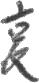

In [6]:
img

In [7]:
from torchvision import transforms
from torch.utils.data import Dataset

In [8]:
import torch.nn.functional as F
import torch

In [9]:
class HWVocab:
    def __init__(self,data_dir):
        self.lables = []
        self.tlables = [] # 独热编码后的标签 type: torch.Tensor
        self.char_dict = {}
        self.initialize_dict(data_dir)
    def initialize_dict(self,path):
        data_dir = pathlib.Path(path)
        for i in data_dir.glob('*'):
            if i not in self.lables:
                self.lables.append(i.name)
        for idx,c in enumerate(self.lables):
            self.char_dict[c] = idx
        self.tlables = F.one_hot(torch.tensor([self.char_dict[x] for x in self.lables]))
        print(f"dict initialized successfully,there's {len(self.char_dict)} lables in the dict.")
        
    def __getitem__(self,c):
        if isinstance(c,list):
            return [self.tlables[self.char_dict[x]] for x in c]
        return self.tlables[self.char_dict[c]]
        
    def lable2char(self,idx):
        if isinstance(idx,torch.Tensor):
            return self.lables[idx.argmax().item()]
        return self.lables[idx]
    
    def __len__(self):
        return len(self.char_dict)

In [10]:
voc_test = HWVocab('../data_for_test/test')

dict initialized successfully,there's 8 lables in the dict.


In [11]:
(voc_test['哀'])

tensor([1, 0, 0, 0, 0, 0, 0, 0])

In [12]:
voc_test.lable2char(voc_test['哀'])

'哀'

In [13]:
len(voc_test)

8

In [14]:
class HWDataset(Dataset):
    # Hand Writting Dataset
    def __init__(self,data_dir):
        self.transform = transforms.Compose([
            transforms.Resize((48,48)),
            transforms.ToTensor()
        ])
        self.to_img = transforms.ToPILImage()
        self.data_dir = data_dir
        self.vocab = HWVocab(data_dir)
        self.data_list = self.get_data_list()
    def get_data_list(self):
        data_list = []
        data_dir = pathlib.Path(self.data_dir)
        for file in data_dir.rglob('*'):
            if file.is_file():
                lable = self.vocab[file.parent.name]
                # img = PIL.Image.open(file)
                # feature = self.transform(img)
                data_list.append((file,lable))
        print(f"lenth of dataset is : {len(data_list)}")
        return data_list
    
    def get_real_feature(self,file):
        img = PIL.Image.open(file)
        feature = self.transform(img)
        return feature
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self,idx):
        return self.get_real_feature(self.data_list[idx][0]),self.data_list[idx][1]
    
    def get_img(self,idx):
        item = self.data_list[idx]
        img = self.to_img(self.get_real_feature(item[0]))
        return (self.vocab.lable2char(item[1]),img)
    
    def __del__(self):
        del self.vocab
        print('delete instance HWDataset,HWVocab')

In [15]:
test = HWDataset(data_dir='../data_for_test/test')

dict initialized successfully,there's 8 lables in the dict.
lenth of dataset is : 477


In [16]:
test[0]

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.9961, 0.9922, 0.9882,  ..., 0.5922, 0.6824, 0.7255],
          [1.0000, 0.9961, 1.0000,  ..., 0.4510, 0.6078, 0.7647],
          [1.0000, 1.0000, 1.0000,  ..., 0.8235, 0.9020, 0.9765]]]),
 tensor([1, 0, 0, 0, 0, 0, 0, 0]))

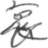

In [17]:
test.get_img(1)[1]

In [18]:
test.get_img(0)

('哀', <PIL.Image.Image image mode=L size=48x48>)

In [19]:
for i in test:
    print(i)
    print(i[0].shape)
    print(i[1])
    break

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.9961, 0.9922, 0.9882,  ..., 0.5922, 0.6824, 0.7255],
         [1.0000, 0.9961, 1.0000,  ..., 0.4510, 0.6078, 0.7647],
         [1.0000, 1.0000, 1.0000,  ..., 0.8235, 0.9020, 0.9765]]]), tensor([1, 0, 0, 0, 0, 0, 0, 0]))
torch.Size([1, 48, 48])
tensor([1, 0, 0, 0, 0, 0, 0, 0])


In [20]:
from torch.utils.data import DataLoader

In [21]:
dl = DataLoader(dataset=test,batch_size=2,shuffle=True)

In [22]:
for x,y in dl:
    print(x)
    print(y)
    break

tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.8667, 0.9647, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.5804, 0.6745, 0.8627],
          [1.0000, 1.0000, 1.0000,  ..., 0.6039, 0.6235, 0.7922]]],


        [[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.8039, 0.9255, 0.9882],
          [1.0000, 1.0000, 1.0000,  ..., 0.5529, 0.6588, 0.8510],
          [1.0000, 1.0000, 1.0000,  ..., 0.7098, 0.7020, 0.7608]]]])
tensor([[0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0]])


In [23]:
import torchvision

In [24]:
resnet101 = torchvision.models.resnet101(pretrained=True)

E:\condaenvs\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\condaenvs\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
list(resnet101.children())[-3:]

[Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): Bottleneck(
     (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [26]:
import torch

In [27]:
test_data = torch.randn([2,3,48,48])
resnet101.eval()
o = resnet101(test_data)
o.shape,o[0][:].argmax()


(torch.Size([2, 1000]), tensor(741))

In [28]:
list(resnet101.children())[0:2]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]

In [29]:
import torch.nn as nn
from torchvision.models import ResNet101_Weights

In [30]:

class HWNet(nn.Module):
    def __init__(self,num_lables):
        super().__init__()
        self.conv1x1 = nn.Conv2d(in_channels=1,out_channels=3,kernel_size=1,stride=1,padding=0,bias=False)
        self.num_labels = num_lables
        resnet101 = torchvision.models.resnet101(weights=ResNet101_Weights.IMAGENET1K_V2)
        self.res101 = nn.Sequential(*list(resnet101.children())[:-1])
        self.dense = nn.Linear(in_features=2048,out_features=self.num_labels)
        
    def forward(self,x):
        x = self.conv1x1(x)
        x = self.res101(x).reshape(len(x),-1)
        x = self.dense(x)
        return x

In [31]:
mynet = HWNet(8)

In [32]:
list(mynet.children())[-2:]

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace=True)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
for x,y in dl:
    print(x)
    print(mynet(x))
    print(y)
    break

tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.7922, 0.9255, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.6902, 0.7922, 0.9412],
          [1.0000, 1.0000, 1.0000,  ..., 0.7843, 0.6745, 0.7255]]],


        [[[1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9961, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9961, 0.9961],
          [1.0000, 1.0000, 1.0000,  ..., 0.8745, 0.9569, 0.9922],
          ...,
          [0.9922, 0.9922, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
          [0.9882, 0.9961, 0.9882,  ..., 1.0000, 1.0000, 1.0000],
          [0.9882, 0.9922, 0.9882,  ..., 1.0000, 1.0000, 1.0000]]]])
tensor([[-0.2056, -0.1036, -0.0716, -0.0065, -0.0982,  0.0319,  0.0019, -0.0800],
        [ 0.0673,  0.0286, -0.0806,  0.0428,  0.0266,  0.0162,  0.0102, -0.0143]],
      